## Fraud Detection in financial transactions - Unsupervised Anomaly Detection

The dataset used for training the model has 284315 non-fraud data points and 492 fraud data points.


In [385]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# scaling
from sklearn.preprocessing import StandardScaler

# autoencoder
import tensorflow as tf
from tensorflow import keras

# deep learning
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.optimizers import Adam

# # code formatter
# %load_ext nb_black

## Reading the dataset and running some stats

In [386]:
# reading the input dataset
df = pd.read_csv("/content/creditcard.csv")

In [387]:
# checking the number of rows and columns
df.shape

(284807, 31)

In [388]:
# checking the first 5 records
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [389]:
# checking for null values
df.isnull().any()

,0
Time,False
V1,False
V2,False
V3,False
V4,False
V5,False
V6,False
V7,False
V8,False
V9,False


In [390]:
# checking for data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The data types look correct!

In [391]:
# checking the data stats
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Exploratory Data Analysis

In [392]:
# checking the count for each class
df["Class"].value_counts()

,count
Class,
0,284315
1,492


The counts for each of the 2 target class shows a highly imbalanced data.

<ipython-input-393-1b0ea60407ad>:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_count = pd.value_counts(df["Class"], sort=True)


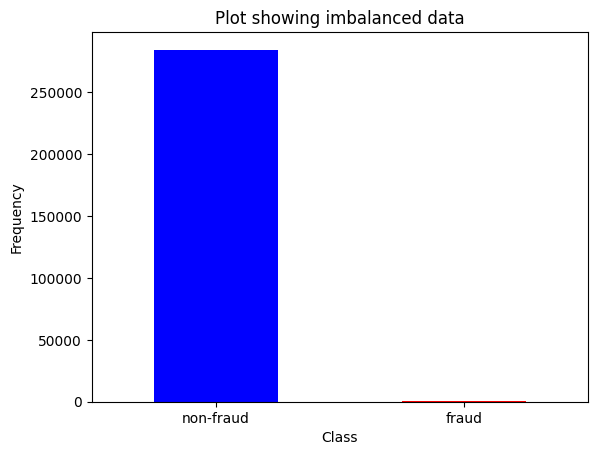

In [393]:
# plotting the class count to show imbalanced dataset

class_name = ["non-fraud", "fraud"]
class_count = pd.value_counts(df["Class"], sort=True)
class_count.plot(kind="bar", rot=0, color=["blue", "red"])
plt.xticks(range(2), class_name)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Plot showing imbalanced data")
plt.show()

The bar graph shows highly imbalanced dataset. There are 284315 data points for non-fraud data as compared to only 492 data points for fraud data.

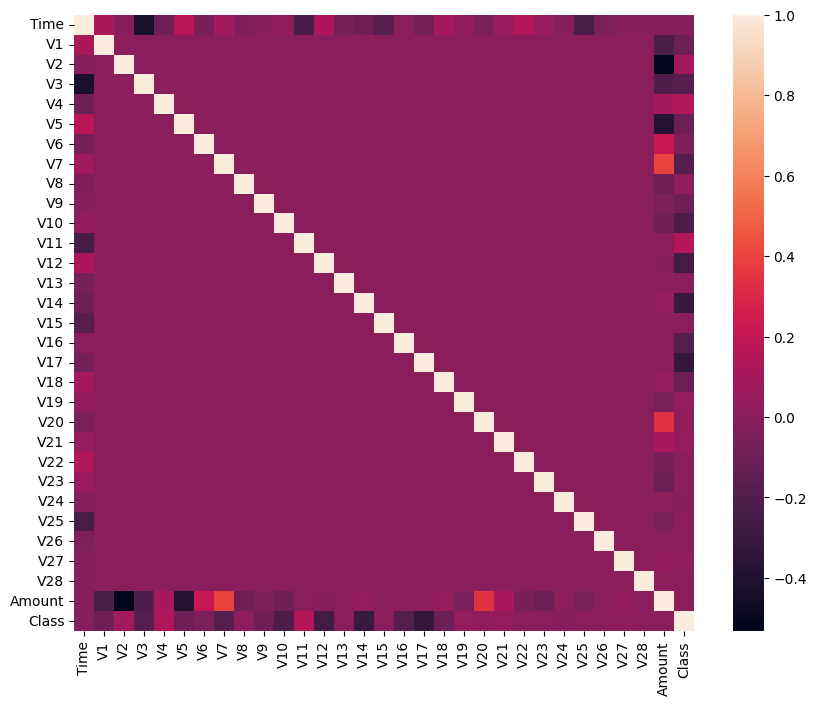

In [394]:
# checking for correlations

fig = plt.figure(figsize=(10, 8))
sns.heatmap(df.corr())
plt.show()

The correlation plot shows no presence of multi collinearity amongst V1 to V28 features (PCA components). Some of these features does show high correlation with the target class (Class) and independent features - Time and Amount. The target class does not seem to have any correlation with Time and Amount.

In [395]:
# setting up separate dataframes for fraud and non_fraud data for detailed analysis and comparison

fraud_data = df[df["Class"] == 1].reset_index(drop=True)
non_fraud_data = df[df["Class"] == 0].reset_index(drop=True)

print("Fraud Data Shape: ", fraud_data.shape)
print("Non-Fraud Data Shape: ", non_fraud_data.shape)

Fraud Data Shape:  (492, 31)
Non-Fraud Data Shape:  (284315, 31)


In [396]:
fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [397]:
non_fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


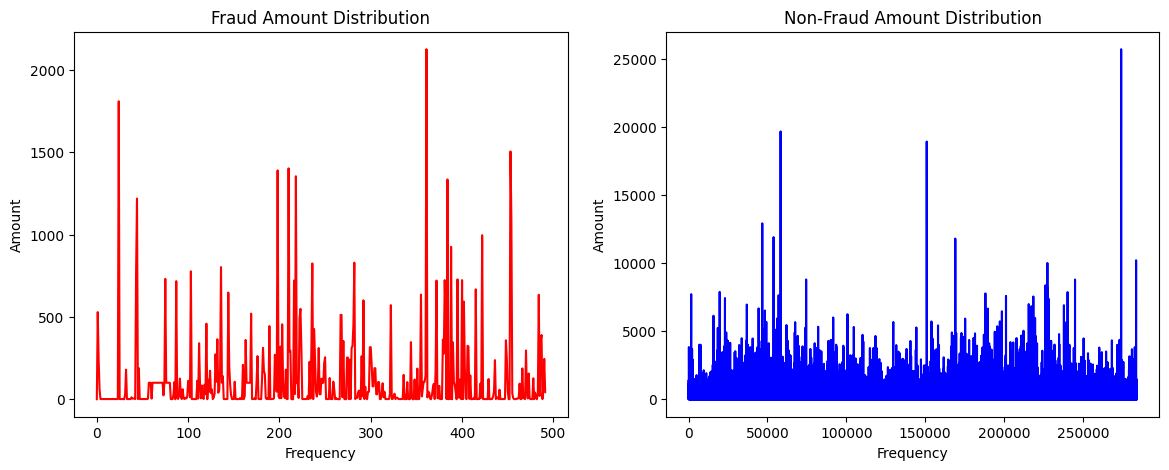

In [398]:
# Amount distribution comparison (line plot)

fig = plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fraud_data["Amount"], color="red")
plt.title("Fraud Amount Distribution")
plt.xlabel("Frequency")
plt.ylabel("Amount")

plt.subplot(1, 2, 2)
plt.plot(non_fraud_data["Amount"], color="blue")
plt.title("Non-Fraud Amount Distribution")
plt.xlabel("Frequency")
plt.ylabel("Amount")

plt.show()

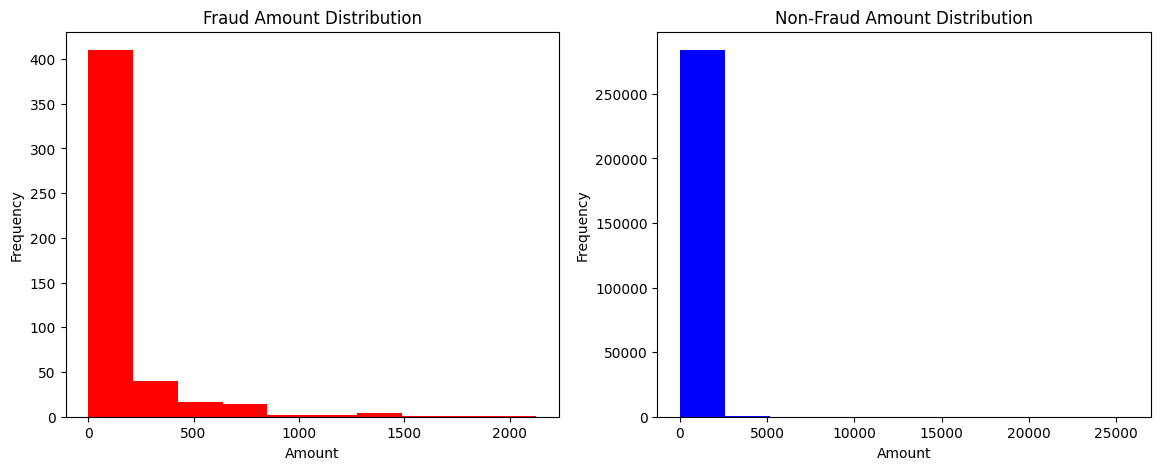

In [399]:
# Amount distribution comparison (histogram)

fig = plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(fraud_data["Amount"], color="red")
plt.title("Fraud Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(non_fraud_data["Amount"], color="blue")
plt.title("Non-Fraud Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")

plt.show()

In the above two plots, we can see that for the Fraud data, majority (more than 400 times) of the times the transaction amount is less than 250 and only a small number (5 to 10) of times the transaction amount is between 1000 to 2500. The max amount is less than 2500.

Whereas, for the non-fraud data, almost all of the times, the transaction amount is between 0 and 2500 and a very few number of times, the amount is between 2500 and 5000. The max amount is a little over 5000.

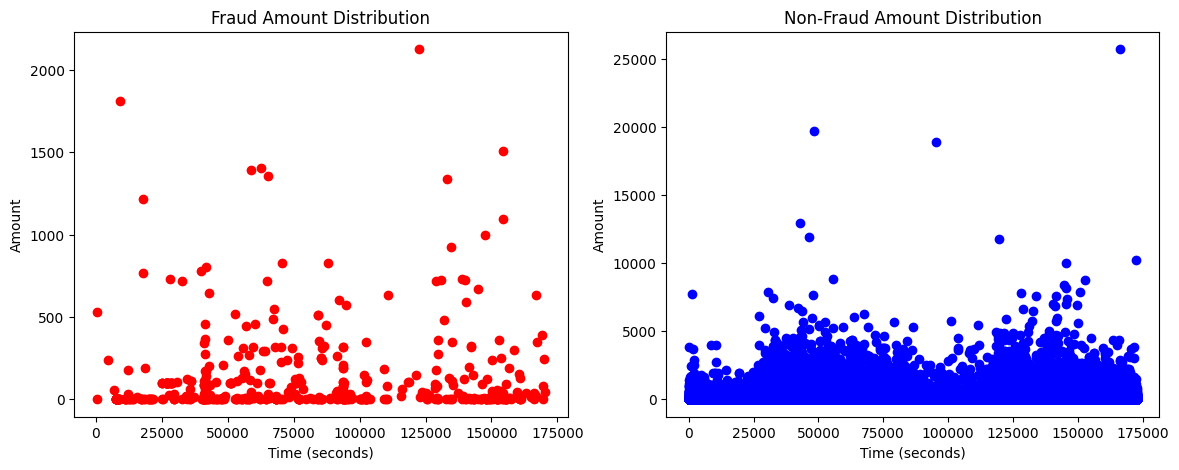

In [400]:
# Time vs. Amount distribution comparison (scatter plot)

fig = plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(fraud_data["Time"], fraud_data["Amount"], color="red")
plt.title("Fraud Amount Distribution")
plt.xlabel("Time (seconds)")
plt.ylabel("Amount")

plt.subplot(1, 2, 2)
plt.scatter(non_fraud_data["Time"], non_fraud_data["Amount"], color="blue")
plt.title("Non-Fraud Amount Distribution")
plt.xlabel("Time (seconds)")
plt.ylabel("Amount")

plt.show()

Based on the above plot, time and amount doesn't seem to show any significant correlation.

## Unsupervised Machine Learning Techniques for Anomaly Detection

In [401]:
# Since the dataset is too large, taking a sample from that data to train models
sampled_data = df.sample(frac=0.1, random_state=42)

print("Sampled Data Shape:", sampled_data.shape)
print("Target Class Value Count: ")
print(sampled_data["Class"].value_counts())

Sampled Data Shape: (28481, 31)
Target Class Value Count: 
Class
0    28435
1       46
Name: count, dtype: int64


In [402]:
# splitting data into X and y

X = sampled_data.drop("Class", axis=1)
y = sampled_data["Class"]

print("X Shape: ", X.shape)
print("y Shape: ", y.shape)
print("========================================")
print("Target Class Value Count: ")
print("Normal Class: ", (y == 0).sum())
print("Fraud Class: ", (y == 1).sum())

fraud = sampled_data[sampled_data["Class"] == 1]
non_fraud = sampled_data[sampled_data["Class"] == 0]

outlier_fraction = len(fraud) / float(len(non_fraud))
print("========================================")
print("Fraud Fraction: ", outlier_fraction)

X Shape:  (28481, 30)
y Shape:  (28481,)
Target Class Value Count: 
Normal Class:  28435
Fraud Class:  46
Fraud Fraction:  0.001617724635132759


## 1. Isolation Forest (Unsupervised Outlier Detection)
Isolation tree is an unsupervised algorithm and therefore it does not need labels to identify the outlier/anomaly. It follows the following steps: Random and recursive partition of data is carried out, which is represented as a tree (random forest).

In [403]:
clf = IsolationForest(n_estimators=100, max_samples=len(X), random_state=42, contamination=outlier_fraction)

clf.fit(X)
y_pred = clf.predict(X)

print("Predicted Anomalous Data Points: ", len(y_pred[y_pred == -1]))
print("Predicted Non Anomalous Data Points: ", len(y_pred[y_pred == 1]))
print("=======================================================")

# replacing -1 by 1 and 1 by 0
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

# evaluation
print("Number of misclassified data points: ", (y_pred != y).sum())
print("\nAccuracy Score :", accuracy_score(y, y_pred))

print("\nClassification Report: ")
print(classification_report(y, y_pred))


Predicted Anomalous Data Points:  47
Predicted Non Anomalous Data Points:  28434
Number of misclassified data points:  63

Accuracy Score : 0.9977879990168884

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.32      0.33      0.32        46

    accuracy                           1.00     28481
   macro avg       0.66      0.66      0.66     28481
weighted avg       1.00      1.00      1.00     28481



In [404]:
# adding the predicted y to the sampled dataset
sampled_data["y_pred_iso"] = y_pred
print(sampled_data["y_pred_iso"].value_counts())

y_pred_iso
0    28434
1       47
Name: count, dtype: int64


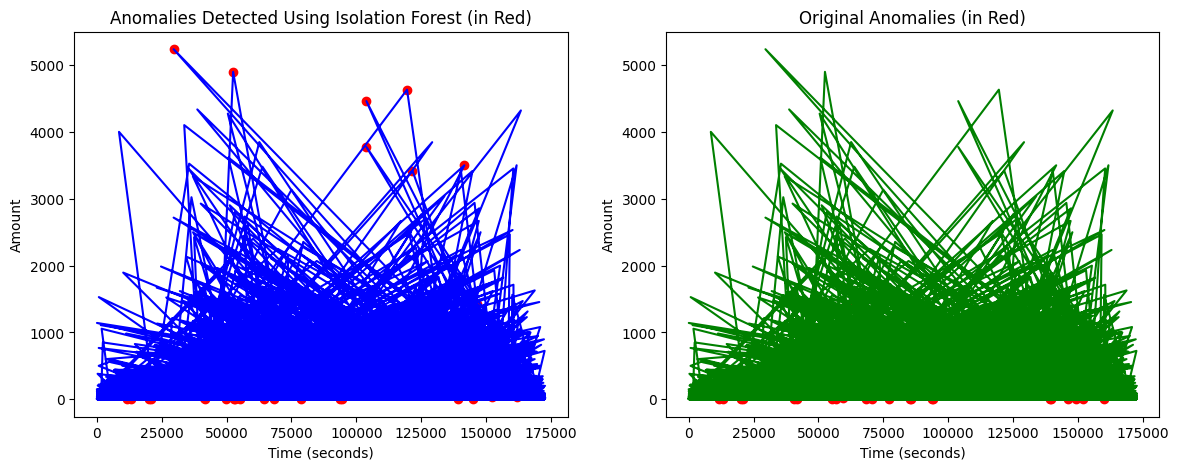

In [405]:
# plotting normal and fraud data points

fig = plt.figure(figsize=(14, 5))

# Isolation Forest Plot
plt.subplot(1, 2, 1)
anomaly_df = sampled_data.loc[sampled_data["y_pred_iso"] == 1, ["Time", "Amount"]]
plt.plot(sampled_data["Time"], sampled_data["Amount"], color="blue")
plt.scatter(anomaly_df["Time"], anomaly_df["Amount"], color="red")
plt.title("Anomalies Detected Using Isolation Forest (in Red)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amount")

# Original data plot
plt.subplot(1, 2, 2)
anomaly_df = sampled_data.loc[sampled_data["Class"] == 1, ["Time", "Amount"]]
plt.plot(sampled_data["Time"], sampled_data["Amount"], color="green")
plt.scatter(anomaly_df["Time"], anomaly_df["Amount"], color="red")
plt.title("Original Anomalies (in Red)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amount")

plt.show()

## 2. Local Outlier Factor (Unsupervised Outlier Detection)
n_neighbors: int, default=20 Number of neighbors to use by default for kneighbors queries. If n_neighbors is larger than the number of samples provided, all samples will be used.

leaf_size: int, default=30 Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

metric: str or callable, default=’minkowski’ metric used for the distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.

p: int, default=2 Parameter for the Minkowski metric from sklearn.metrics.pairwise.pairwise_distances. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.

In [406]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=20,
    algorithm="auto",
    leaf_size=30,
    metric="minkowski",
    p=2,
    metric_params=None,
    contamination=outlier_fraction,
)

y_pred_lof = lof.fit_predict(X)

print("Predicted Anomalous Data Points: ", len(y_pred_lof[y_pred_lof == -1]))
print("Predicted Non Anomalous Data Points: ", len(y_pred_lof[y_pred_lof == 1]))
print("================================================================")


# replacing -1 by 1 and 1 by 0
y_pred_lof[y_pred_lof == 1] = 0
y_pred_lof[y_pred_lof == -1] = 1

# evaluation
print("Number of misclassified data points: ", (y_pred_lof != y).sum())
print("\nAccuracy Score :", accuracy_score(y, y_pred_lof))

print("\nClassification Report: ")
print(classification_report(y, y_pred_lof))

Predicted Anomalous Data Points:  47
Predicted Non Anomalous Data Points:  28434
Number of misclassified data points:  91

Accuracy Score : 0.9968048874688389

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.02      0.02      0.02        46

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



In [407]:
# adding the predicted y to the sampled dataset
sampled_data["y_pred_lof"] = y_pred_lof
print(sampled_data["y_pred_lof"].value_counts())

y_pred_lof
0    28434
1       47
Name: count, dtype: int64


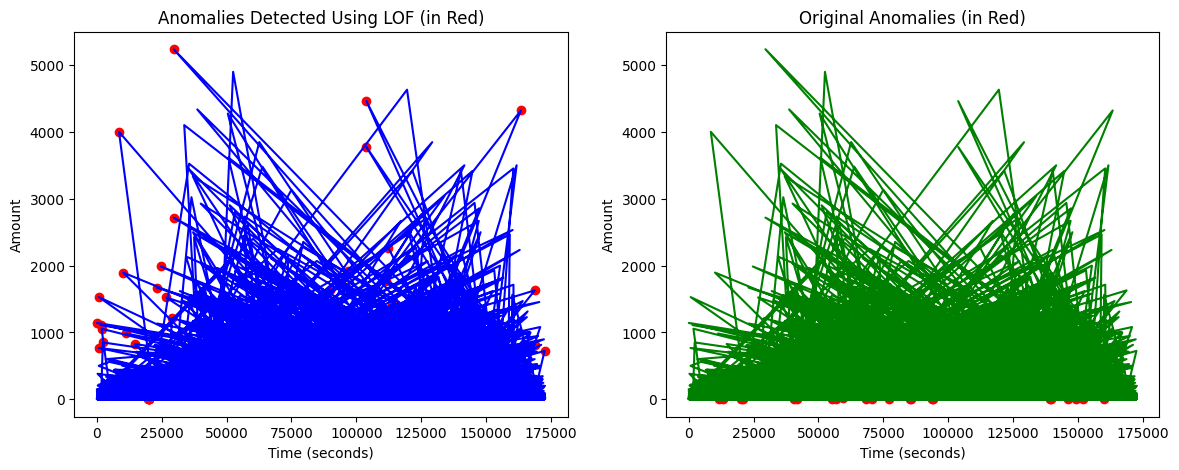

In [408]:
# plotting normal and fraud data points

fig = plt.figure(figsize=(14, 5))

# LOF Plot
plt.subplot(1, 2, 1)
anomaly_df = sampled_data.loc[sampled_data["y_pred_lof"] == 1, ["Time", "Amount"]]
plt.plot(sampled_data["Time"], sampled_data["Amount"], color="blue")
plt.scatter(anomaly_df["Time"], anomaly_df["Amount"], color="red")
plt.title("Anomalies Detected Using LOF (in Red)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amount")

# Original Plot
plt.subplot(1, 2, 2)
anomaly_df = sampled_data.loc[sampled_data["Class"] == 1, ["Time", "Amount"]]
plt.plot(sampled_data["Time"], sampled_data["Amount"], color="green")
plt.scatter(anomaly_df["Time"], anomaly_df["Amount"], color="red")
plt.title("Original Anomalies (in Red)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amount")

plt.show()

## 3. Deep Learning - AutoEncoders

In [409]:
# creating a smaller sample for handling imbalanced dataset.

normal_trans = df[df["Class"] == 0].sample(2000)
fraud_trans = df[df["Class"] == 1]

import pandas as pd
dl_sample_data = pd.concat([normal_trans, fraud_trans]).reset_index(drop=True)

# dl_sample_data = normal_trans.append(fraud_trans).reset_index(drop=True)

print("Target Class Value Counts: ")
print(dl_sample_data["Class"].value_counts())

Target Class Value Counts: 
Class
0    2000
1     492
Name: count, dtype: int64


In [410]:
# splitting the data

X = dl_sample_data.drop("Class", axis=1)
y = dl_sample_data["Class"]

print("X Shape: ", X.shape)
print("y Shape: ", y.shape)

X Shape:  (2492, 30)
y Shape:  (2492,)


### Visualize the data with t-SNE
TNSE(t-distributed Stochastic Neighbor Embedding) is one of the dimensionality reduction method other than PCA and SVD. This will supress some noise and speed up the computation of pairwise distance between samples.

In [411]:
def dimensionality_plot(X, y):

    #     sns.set(style='whitegrid', palette='muted')

    # Initializing TSNE object with 2 principal components
    tsne = TSNE(n_components=2, random_state=42)

    # Fitting the data
    X_trans = tsne.fit_transform(X)

    plt.figure(figsize=(10, 6))

    plt.scatter(
        X_trans[np.where(y == 0), 0],
        X_trans[np.where(y == 0), 1],
        marker="o",
        color="b",
        linewidth=1,
        alpha=0.8,
        label="Normal",
    )

    plt.scatter(
        X_trans[np.where(y == 1), 0],
        X_trans[np.where(y == 1), 1],
        marker="o",
        color="r",
        linewidth=1,
        alpha=0.8,
        label="Fraud",
    )

    plt.legend(loc="best")

    plt.show()

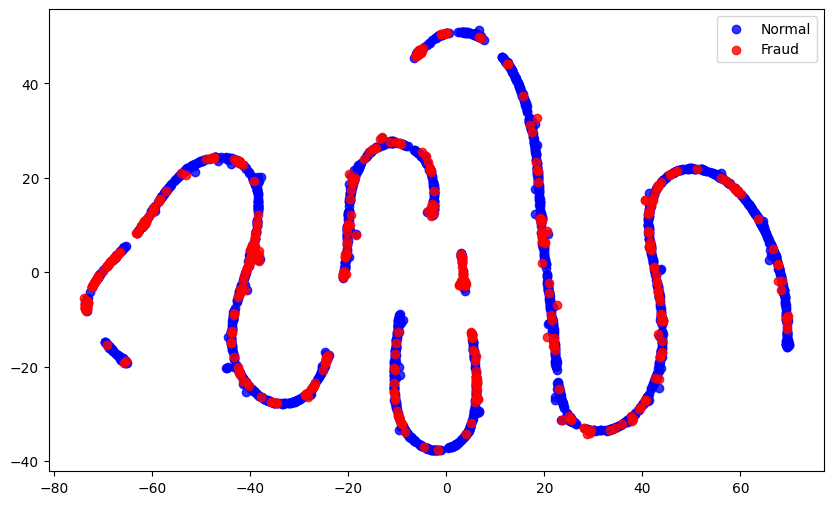

In [412]:
# plotting the dimensionality_plot for original data

dimensionality_plot(X, y)

In [413]:
# scaling the data

scaler = StandardScaler().fit_transform(X)

# scaled data
X_scaled_normal = scaler[y == 0]
X_scaled_fraud = scaler[y == 1]

In [414]:
# setting up the input shape (equal to number of features)
input_layer = Input(shape=(X.shape[1],))

# building the encoder network
encoded = Dense(100, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(
    input_layer
)
encoded = Dense(50, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(
    encoded
)
encoded = Dense(25, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(
    encoded
)
encoded = Dense(12, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(
    encoded
)
encoded = Dense(6, activation="relu")(encoded)

# building the decoder network
decoded = Dense(12, activation="tanh")(encoded)
decoded = Dense(25, activation="tanh")(decoded)
decoded = Dense(50, activation="tanh")(decoded)
decoded = Dense(100, activation="tanh")(decoded)

output_layer = Dense(X.shape[1], activation="sigmoid")(decoded)

# creating the model
autoencoder = Model(input_layer, output_layer)

autoencoder.summary()

Model: "functional_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 100)                 │           3,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 12)                  │             312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 6)                   │              78 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 12)                  │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 25)                  │             325 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 30)                  │           3,030 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,654 (76.77 KB)

 Trainable params: 19,654 (76.77 KB)

 Non-trainable params: 0 (0.00 B)

In [415]:
# compiling the auto encoder model
autoencoder.compile(optimizer="adam", loss="mse")

# training the auto encoder model on non fraud data (we don't need too many observations for model learning in this case)
history = autoencoder.fit(
    X_scaled_normal,
    X_scaled_normal,
    batch_size=32,
    epochs=50,
    shuffle=True,
    validation_split=0.20,
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.7651 - val_loss: 0.6246
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5463 - val_loss: 0.5802
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4888 - val_loss: 0.5567
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4711 - val_loss: 0.5383
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4580 - val_loss: 0.5207
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4377 - val_loss: 0.5086
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4443 - val_loss: 0.4998
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4147 - val_loss: 0.4923
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4092 - val_loss: 0.4859
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4045 - val_loss: 0.4798
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3984 - val_loss: 0.4728
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4102 - val_lo

Text(0.5, 1.0, 'Loss Curves')

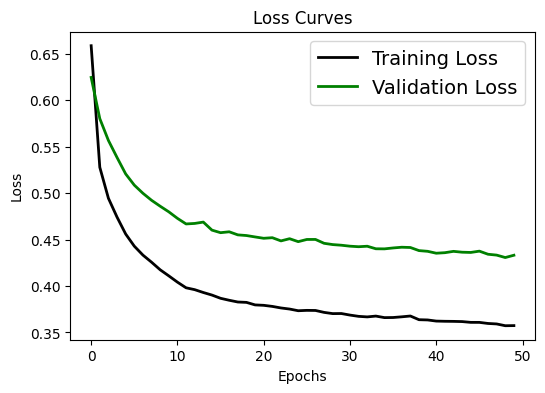

In [416]:
# Loss curve

plt.figure(figsize=[6, 4])
plt.plot(history.history["loss"], "black", linewidth=2.0)
plt.plot(history.history["val_loss"], "green", linewidth=2.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)

In [417]:
# creating the sequential model and adding the trainined weights till the fifth layer (till where the latent representation exists)

latent_model = Sequential()
latent_model.add(autoencoder.layers[0])
latent_model.add(autoencoder.layers[1])
latent_model.add(autoencoder.layers[2])
latent_model.add(autoencoder.layers[3])
latent_model.add(autoencoder.layers[4])

In [418]:
# generating the hidden representation of the 2 classes

normal_datapoints = latent_model.predict(X_scaled_normal)
fraud_datapoints = latent_model.predict(X_scaled_fraud)

# creating a dataframe of latent representation of the data

encoded_X = np.append(normal_datapoints, fraud_datapoints, axis=0)

y_normal = np.zeros(normal_datapoints.shape[0])
y_fraud = np.ones(fraud_datapoints.shape[0])
encoded_y = np.append(y_normal, y_fraud, axis=0)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


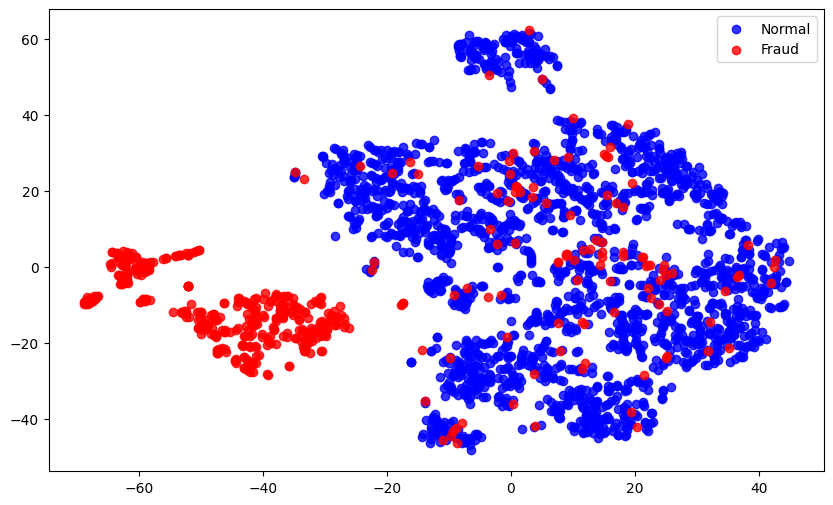

In [419]:
# plotting the TSNE function again to visualize the latent data

dimensionality_plot(encoded_X, encoded_y)

In [420]:
# splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# splitting the encoded data
X_enc_train, X_enc_test, y_enc_train, y_enc_test = train_test_split(
    encoded_X, encoded_y, test_size=0.25
)

print(
    f"Encoded train data X: {X_enc_train.shape}, Y: {y_enc_train.shape}, X_test :{X_enc_test.shape}, Y_test: {y_enc_test.shape}"
)
print(
    f"Actual train & test data X: {X_train.shape}, Y: {X_train.shape}, X_test :{X_test.shape}, Y_test: {y_test.shape}"
)

Encoded train data X: (1869, 12), Y: (1869,), X_test :(623, 12), Y_test: (623,)
Actual train & test data X: (1869, 30), Y: (1869, 30), X_test :(623, 30), Y_test: (623,)


In [421]:
# applying support vector classifier on the encoded data

svc_clf = SVC(probability=True)

svc_clf.fit(X_enc_train, y_enc_train)

svc_predictions = svc_clf.predict(X_enc_test)

# y_probability
y_proba = svc_clf.predict_proba(X_enc_test)[:, 1]

# precision recall score
average_precision = average_precision_score(y_enc_test, y_proba)

print("Accuracy of SVC {:.2f}".format(accuracy_score(y_enc_test, svc_predictions)))
print("==============================================================")

print(f"ROC-AUC Score: {roc_auc_score(y_enc_test, y_proba):.2f}")
print("==============================================================")

print(f"Average Precision-Recall Score: {average_precision:.2f}")
print("==============================================================")

print(
    "\nClassification report \n {0}".format(
        classification_report(y_enc_test, svc_predictions)
    )
)

Accuracy of SVC 0.95
ROC-AUC Score: 0.92
Average Precision-Recall Score: 0.90

Classification report 
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       499
         1.0       1.00      0.77      0.87       124

    accuracy                           0.95       623
   macro avg       0.97      0.88      0.92       623
weighted avg       0.96      0.95      0.95       623



In [422]:
# applying logistic regression model on the encoded data

lr_clf = LogisticRegression()

lr_clf.fit(X_enc_train, y_enc_train)

predictions = lr_clf.predict(X_enc_test)

# y_probability
y_proba = lr_clf.predict_proba(X_enc_test)[:, 1]

# precision recall score
average_precision = average_precision_score(y_enc_test, y_proba)

print("Accuracy score is : {:.2f}".format(accuracy_score(y_enc_test, predictions)))
print("==============================================================")

print(f"ROC-AUC Score: {roc_auc_score(y_enc_test, y_proba):.2f}")
print("==============================================================")

print(f"Average Precision-Recall Score: {average_precision:.2f}")
print("==============================================================")

print(
    "\nClassification report \n {0}".format(
        classification_report(y_enc_test, predictions)
    )
)

Accuracy score is : 0.92
ROC-AUC Score: 0.89
Average Precision-Recall Score: 0.86

Classification report 
               precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       499
         1.0       1.00      0.59      0.74       124

    accuracy                           0.92       623
   macro avg       0.95      0.79      0.85       623
weighted avg       0.93      0.92      0.91       623



## 4. CNN - Convolution Neural Network

In [423]:
print(X.shape)
print(y.shape)

(2492, 30)
(2492,)


In [424]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)
print("y_train Shape", y_train.shape)
print("y_test Shape", y_test.shape)

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train Shape (1869, 30)
X_test Shape (623, 30)
y_train Shape (1869,)
y_test Shape (623,)


In [425]:
# changing the shape of the data so that the model can process it
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# verifying the changed shape
X_train.shape, X_test.shape

((1869, 30, 1), (623, 30, 1))

In [426]:
model = Sequential()

model.add(
    Conv1D(filters=32, kernel_size=2, activation="relu", input_shape=X_train[0].shape)
)
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv1D(filters=64, kernel_size=2, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=2, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)                   │ (None, 29, 32)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 29, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 29, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 28, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 28, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 27, 128)             │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 27, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 27, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 3456)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 64)                  │         221,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,977 (949.13 KB)

 Trainable params: 242,529 (947.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [427]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC()],
)

# fitting the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9079 - auc_7: 0.8833 - loss: 0.3209 - val_accuracy: 0.9422 - val_auc_7: 0.9687 - val_loss: 0.4453
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9695 - auc_7: 0.9820 - loss: 0.1026 - val_accuracy: 0.9518 - val_auc_7: 0.9754 - val_loss: 0.3091
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9641 - auc_7: 0.9796 - loss: 0.1320 - val_accuracy: 0.9695 - val_auc_7: 0.9783 - val_loss: 0.2162
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9657 - auc_7: 0.9775 - loss: 0.1166 - val_accuracy: 0.9663 - val_auc_7: 0.9755 - val_loss: 0.1925
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9684 - auc_7: 0.9838 - loss: 0.0989 - val_accuracy: 0.9631 - val_auc_7: 0.9822 - val_loss: 0.1549
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9704 - auc_7: 0.9899 - loss: 0.0834 - val_accuracy: 0.9647 - val_auc_7: 0.9780 - val_loss: 0.1315
Epoch 7/50
59/59 ━━━━━

## ------------------------------------------------------------------------------------------------------------------------

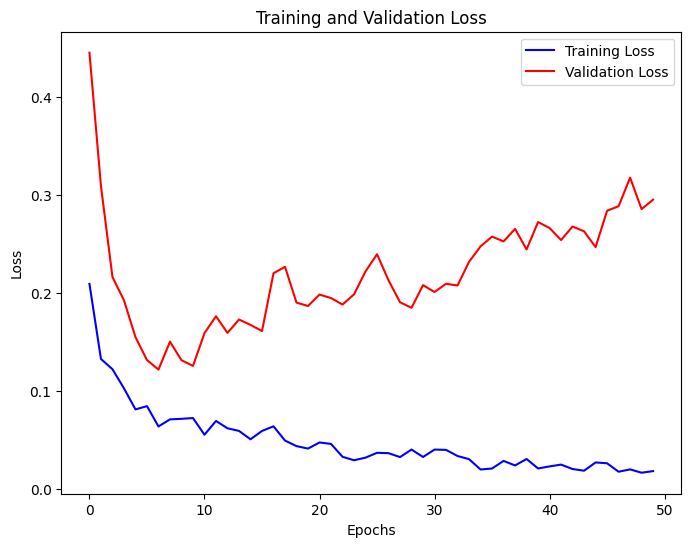

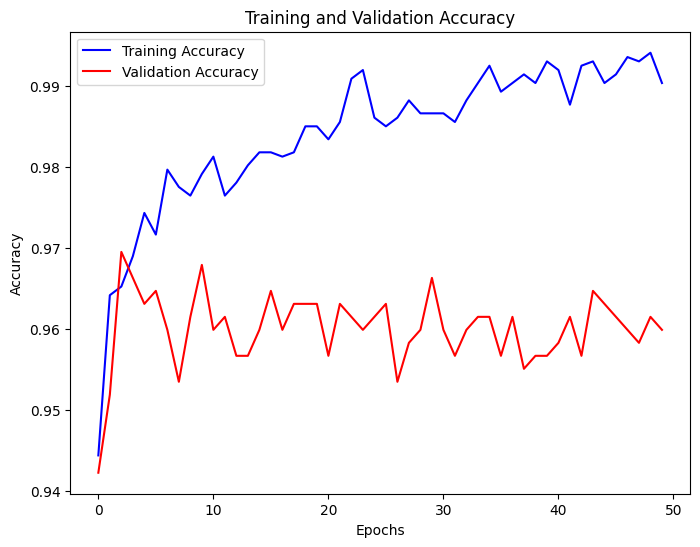

In [428]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=[8, 6])
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=[8, 6])
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# --------------------------------------------------------------------------------------------

Text(0.5, 1.0, 'Loss Curves')

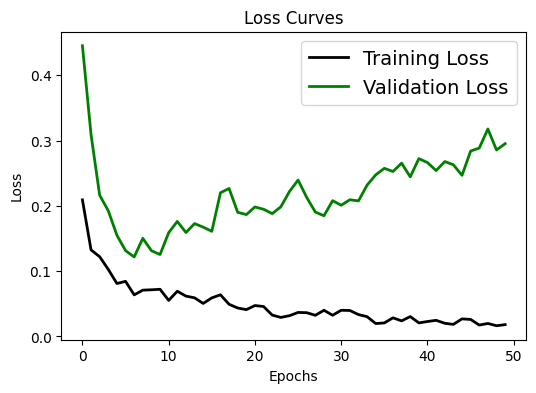

In [429]:
# Loss curve

plt.figure(figsize=[6, 4])
plt.plot(history.history["loss"], "black", linewidth=2.0)
plt.plot(history.history["val_loss"], "green", linewidth=2.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

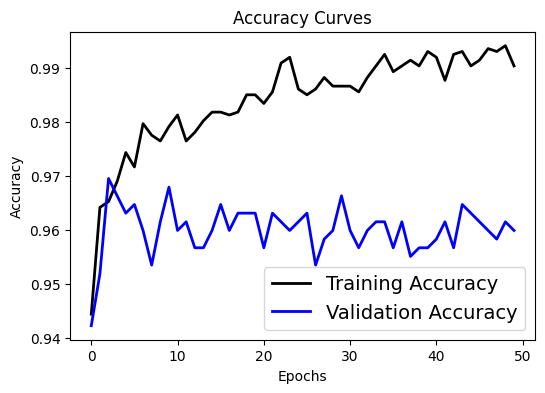

In [430]:
# Accuracy curve

plt.figure(figsize=[6, 4])
plt.plot(history.history["accuracy"], "black", linewidth=2.0)
plt.plot(history.history["val_accuracy"], "blue", linewidth=2.0)
plt.legend(["Training Accuracy", "Validation Accuracy"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.title("Accuracy Curves", fontsize=12)

In [ ]:
# AUC curve

plt.figure(figsize=[6, 4])
plt.plot(history.history["auc"], "black", linewidth=2.0)
plt.plot(history.history["val_auc"], "orange", linewidth=2.0)
plt.legend(["Training AUC", "Validation AUC"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("AUC", fontsize=10)
plt.title("AUC Curves", fontsize=12)

In [ ]:
print("Average AUC Score: ", np.mean(history.history["val_auc"]))

In [ ]:
print("Average AUC Score: ", np.mean(history.history["val_auc"]))
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Perform KMeans clustering on the encoded data
kmeans = KMeans(n_clusters=2, random_state=42)  # Since we have 2 classes (fraud and normal)
kmeans.fit(encoded_X)

# Predicted clusters (fraud vs normal)
predicted_clusters = kmeans.labels_

# Calculate Silhouette Score
silhouette = silhouette_score(encoded_X, predicted_clusters)
print(f"Silhouette Score: {silhouette:.4f}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(encoded_X, predicted_clusters)
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

# Calculate Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(encoded_X, predicted_clusters)
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
